# lesswrong challenge: Colonizing the SuperHyperSphere

problem: https://www.lesswrong.com/posts/Rpjrwspx2QZuHbmPE/d-and-d-sci-fi-colonizing-the-superhypersphere-evaluation

submit: https://h-b-p.github.io/d-and-d-sci-SuperHyperSphere/

## setup

In [35]:
!wget https://raw.githubusercontent.com/sfgeekgit/lesswrongDataDzppg/main/cleared_sites_formated.csv
!wget https://raw.githubusercontent.com/sfgeekgit/lesswrongDataDzppg/main/measured_data.csv

'wget' is not recognized as an internal or external command,
operable program or batch file.
'wget' is not recognized as an internal or external command,
operable program or batch file.


In [61]:
import pandas as pd
from sklearn.model_selection import train_test_split
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
import matplotlib.pyplot as plt

device = 'cuda' if torch.cuda.is_available() else 'cpu'

In [37]:
# import data
unlabeled = pd.read_csv('cleared_sites_formated.csv')
labeled = pd.read_csv('measured_data.csv')
n_features = labeled.shape[1] - 2

In [38]:
# split into training and test sets
train_data2, test_data = train_test_split(labeled, test_size =.1, random_state = 1)
train_labels = train_data2['ZPPG_Performance']
train_data = train_data2.drop(['ZPPG_id', 'ZPPG_Performance'], axis=1)

print(f'train data: {len(train_data)}')
print(f'test data:  {len(test_data)}')

train data: 9366
test data:  1041


## utils

In [39]:
@torch.no_grad()
def evaluate(model, dataset):
  model.eval()
  val = dataset.drop(['ZPPG_id', 'ZPPG_Performance'], axis=1)
  preds = model(torch.tensor(val.values).float().to(device))
  labels = torch.tensor(dataset['ZPPG_Performance'].values).view(-1, 1).to(device)
  diff = preds.detach() - labels
  error = diff.abs().mean().item()
  model.train()
  return error

In [40]:
@torch.no_grad()
def topn(model, dataset, n=15):
  model.eval()
  to_drop = ['ZPPG_id']
  if 'ZPPG_Performance' in dataset: to_drop.append('ZPPG_Performance')
  preds = model(torch.tensor(dataset.drop(to_drop, axis=1).values).float().to(device))
  ids = dataset['ZPPG_id']
  preds_id = list(zip(
    preds.view(-1).tolist(),
    ids.values.tolist()))
  return sorted(preds_id, reverse=True)[:n]

## model and train

In [41]:
class MLP(nn.Module):
  def __init__(self, n_inputs=n_features, hidden=64, dropout=0.2):
    super().__init__()
    self.model = nn.Sequential(
        nn.Linear(n_inputs, hidden),
        nn.BatchNorm1d(hidden),
        nn.ReLU(),
        nn.Dropout(dropout),
        nn.Linear(hidden, hidden),
        nn.BatchNorm1d(hidden),
        nn.ReLU(),
        nn.Dropout(dropout),
        nn.Linear(hidden, hidden),
        nn.BatchNorm1d(hidden),
        nn.ReLU(),
        nn.Dropout(dropout),
        nn.Linear(hidden, hidden),
        nn.BatchNorm1d(hidden),
        nn.ReLU(),
        nn.Dropout(dropout),
        nn.Linear(hidden, hidden),
        nn.BatchNorm1d(hidden),
        nn.ReLU(),
        nn.Dropout(dropout),
        nn.Linear(hidden, hidden),
        nn.BatchNorm1d(hidden),
        nn.ReLU(),
        nn.Dropout(dropout),
        nn.Linear(hidden, hidden),
        nn.BatchNorm1d(hidden),
        nn.ReLU(),
        nn.Dropout(dropout),
        nn.Linear(hidden, 1),
    )
  def forward(self, x):
    output = self.model(x)
    return output

In [42]:
model = MLP().to(device)

In [95]:
def train(model, df, epochs=100000, log_every=200, lr=3e-4, weight_decay=0.01):
  model.train()
  optimizer = optim.AdamW(model.parameters(), lr=lr, weight_decay=weight_decay)
  labels = torch.tensor(df['ZPPG_Performance'].values).float().view(-1, 1).to(device)
  data = df.drop(['ZPPG_id', 'ZPPG_Performance'], axis=1)
  data = torch.tensor(data.values).float().to(device)
  for epoch in range(epochs):
    predictions = model(data)
    loss = F.mse_loss(predictions, labels)
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()
    if epoch % log_every == 0:
      error = evaluate(model, df)
      print(f'{epoch=:5} {loss.item()=:7.4f} {error=:7.4f}')
  model.eval()

train(model, labeled)

epoch=    0 loss.item()= 0.0006 error= 0.0740
epoch=  200 loss.item()= 0.0006 error= 0.0702
epoch=  400 loss.item()= 0.0006 error= 0.0684
epoch=  600 loss.item()= 0.0006 error= 0.0685
epoch=  800 loss.item()= 0.0006 error= 0.0688


KeyboardInterrupt: 

In [ ]:
# save
# ----
# torch.save(model.state_dict(), 'weights/mlp2.pt')

# load
# ----
# m = MLP().to(device)
# m.load_state_dict(torch.load('weights/mlp.pt'))

## eval

In [44]:
# predict solution
topn(model, unlabeled)

[(0.5023767948150635, 107278),
 (0.5023516416549683, 96286),
 (0.4998026490211487, 23565),
 (0.4972749352455139, 9344),
 (0.4961569905281067, 16423),
 (0.493185818195343, 905),
 (0.49086564779281616, 80395),
 (0.48947596549987793, 87620),
 (0.48929280042648315, 93762),
 (0.48920321464538574, 94408),
 (0.48849719762802124, 83512),
 (0.4879477620124817, 40297),
 (0.4876636266708374, 62718),
 (0.4860466718673706, 44719),
 (0.4857943654060364, 38055)]

In [ ]:
# validation
topn(model, test_data)
topn(model, train_data2)

[(1.8702857494354248, 3412),
 (1.8266371488571167, 2695),
 (1.8240541219711304, 7487),
 (1.8221070766448975, 2509),
 (1.821927547454834, 3773),
 (1.8169137239456177, 8721),
 (1.8135265111923218, 5386),
 (1.8075464963912964, 5751),
 (1.8061460256576538, 7243),
 (1.7997924089431763, 2004),
 (1.797755241394043, 5072),
 (1.7943958044052124, 4148),
 (1.7933684587478638, 6989),
 (1.791631817817688, 7146),
 (1.7850587368011475, 5667)]

## experiment: balance the dataset

In [73]:
def bucket_histogram(df):
    grouped = df.groupby('bucket', observed=True)
    grouped['bucket'].count().plot(kind='bar')
    plt.xlabel('bucket')
    plt.ylabel('count')
    plt.title('10% buckets of ZPPG_Performance')
    plt.xticks(rotation=45)
    plt.show()

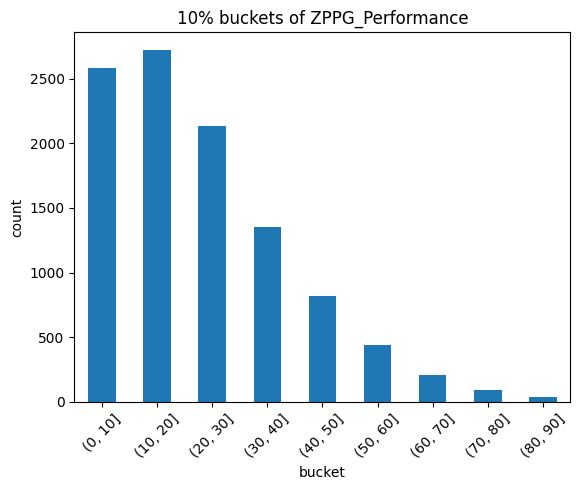

In [75]:
df = labeled.copy()
bins = range(0, 100, 10)
df['bucket'] = pd.cut(df['ZPPG_Performance'] * 100, bins=bins)
bucket_histogram(df)

### sample down

In [89]:
def sample(df, n=50):
    grouped = df.groupby('bucket', observed=True)
    samples = [group.sample(min(len(group), 50)) for _, group in grouped]
    sampled = pd.concat(samples, ignore_index=True)
    return sampled.drop(['bucket'], axis=1)

sampled = sample(df)

In [99]:
sampled_model = MLP().to(device)

In [113]:
train(sampled_model, sampled, epochs=30000, lr=1e-6)

epoch=    0 loss.item()= 0.0012 error= 0.0438
epoch=  200 loss.item()= 0.0013 error= 0.0437
epoch=  400 loss.item()= 0.0012 error= 0.0438
epoch=  600 loss.item()= 0.0011 error= 0.0437
epoch=  800 loss.item()= 0.0012 error= 0.0438
epoch= 1000 loss.item()= 0.0013 error= 0.0440
epoch= 1200 loss.item()= 0.0013 error= 0.0438
epoch= 1400 loss.item()= 0.0012 error= 0.0436
epoch= 1600 loss.item()= 0.0013 error= 0.0432
epoch= 1800 loss.item()= 0.0013 error= 0.0438
epoch= 2000 loss.item()= 0.0013 error= 0.0439
epoch= 2200 loss.item()= 0.0012 error= 0.0438
epoch= 2400 loss.item()= 0.0011 error= 0.0439
epoch= 2600 loss.item()= 0.0011 error= 0.0437
epoch= 2800 loss.item()= 0.0013 error= 0.0441
epoch= 3000 loss.item()= 0.0012 error= 0.0438
epoch= 3200 loss.item()= 0.0013 error= 0.0439
epoch= 3400 loss.item()= 0.0014 error= 0.0434
epoch= 3600 loss.item()= 0.0015 error= 0.0439
epoch= 3800 loss.item()= 0.0014 error= 0.0438
epoch= 4000 loss.item()= 0.0012 error= 0.0441
epoch= 4200 loss.item()= 0.0013 er

In [114]:
# predict solution
topn(sampled_model, unlabeled)

[(0.7847162485122681, 76804),
 (0.7804363369941711, 71793),
 (0.7791130542755127, 72376),
 (0.7736898064613342, 94408),
 (0.7723697423934937, 18369),
 (0.7723492383956909, 952),
 (0.7691422700881958, 7101),
 (0.7679545283317566, 88956),
 (0.7659670114517212, 58945),
 (0.765868604183197, 104260),
 (0.7655607461929321, 59917),
 (0.765295147895813, 479),
 (0.7651427984237671, 105607),
 (0.7650604248046875, 93762),
 (0.764275074005127, 81319)]

### sample up

In [123]:
def upsample(df, n=2000):
    grouped = df.groupby('bucket', observed=True)
    samples = [(group if len(group) > n else group.sample(n, replace=True)) for _, group in grouped]
    sampled = pd.concat(samples, ignore_index=True)
    return sampled.drop(['bucket'], axis=1)

upsampled = upsample(df)

In [124]:
upsampled_model = MLP().to(device)

In [129]:
train(upsampled_model, upsampled, epochs=20000)

epoch=    0 loss.item()= 0.0011 error= 0.0933
epoch=  200 loss.item()= 0.0011 error= 0.0923
epoch=  400 loss.item()= 0.0011 error= 0.0928
epoch=  600 loss.item()= 0.0011 error= 0.0928
epoch=  800 loss.item()= 0.0011 error= 0.0938
epoch= 1000 loss.item()= 0.0011 error= 0.0925
epoch= 1200 loss.item()= 0.0011 error= 0.0933
epoch= 1400 loss.item()= 0.0011 error= 0.0922
epoch= 1600 loss.item()= 0.0011 error= 0.0931
epoch= 1800 loss.item()= 0.0011 error= 0.0934
epoch= 2000 loss.item()= 0.0011 error= 0.0927
epoch= 2200 loss.item()= 0.0011 error= 0.0925
epoch= 2400 loss.item()= 0.0011 error= 0.0921
epoch= 2600 loss.item()= 0.0011 error= 0.0928
epoch= 2800 loss.item()= 0.0011 error= 0.0913
epoch= 3000 loss.item()= 0.0011 error= 0.0926
epoch= 3200 loss.item()= 0.0011 error= 0.0919
epoch= 3400 loss.item()= 0.0011 error= 0.0921
epoch= 3600 loss.item()= 0.0011 error= 0.0928
epoch= 3800 loss.item()= 0.0011 error= 0.0924
epoch= 4000 loss.item()= 0.0011 error= 0.0942
epoch= 4200 loss.item()= 0.0011 er

In [130]:
# predict solution
topn(upsampled_model, unlabeled)

[(0.6616739630699158, 23565),
 (0.650332510471344, 16423),
 (0.649997353553772, 96286),
 (0.6470462679862976, 8415),
 (0.6463005542755127, 106276),
 (0.6435211896896362, 93762),
 (0.6419152021408081, 110080),
 (0.6417442560195923, 7101),
 (0.6394185423851013, 87620),
 (0.6392368078231812, 52609),
 (0.6378263235092163, 18123),
 (0.6370429992675781, 107278),
 (0.6351938247680664, 58945),
 (0.6351312398910522, 10265),
 (0.6350407600402832, 34438)]